# Imports: 

In [3]:
import pandas as pd
import os
import re

import rdkit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, MolToFile
from rdkit.Chem import Draw

import json

import umap
import matplotlib.pyplot as plt
import seaborn as sns
cols = sns.color_palette()

import numpy as np
from rdkit.Chem import AllChem

import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

import holoviews as hv 
import bokeh.io
import bokeh.plotting
import colorcet as cc

import hvplot.pandas

from random import sample

import pandas as pd
import numpy as np
import sys
sys.path.append('/home/ajinich/Documents/repos/pySankey')
from pysankey import sankey

%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


# Functions

In [129]:
def choose_k(data, max_clus):
    "Helper function to choose the number of clusters for KMeans."
    
    k_tests = np.arange(2, max_clus)
    wcss = []
    silhouettes_ = []
    for k in tqdm.tqdm(k_tests): 
        clustering = KMeans(k, random_state = 42).fit(data)
        wcss.append(clustering.inertia_)
        silhouettes_.append(silhouette_score(data, clustering.predict(data)))
    
    
    return wcss, silhouettes_

# Data: 

File source: UP_Rhea_to_smiles.ipynb

In [5]:
file_in = '../data/tests/df_UP_rhea_chebi_smiles.csv'
df_UP_rhea_chebi_smiles = pd.read_csv( file_in )
print(df_UP_rhea_chebi_smiles.shape)
df_UP_rhea_chebi_smiles.head(3)

(7365, 5)


,Entry,RheaID,type,ChEBI,smiles
0,A0A089QRB9,50344,LEFT,CHEBI_15378,[H+]
1,A0A089QRB9,50344,LEFT,CHEBI_57327,C[C@@H](C([O-])=O)C(=O)SCCNC(=O)CCNC(=O)[C@H](...
2,A0A089QRB9,50344,LEFT,CHEBI_57783,NC(=O)C1=CN(C=CC1)[C@@H]1O[C@H](COP([O-])(=O)O...


In [6]:
df_UP_rhea_chebi_smiles = df_UP_rhea_chebi_smiles[~df_UP_rhea_chebi_smiles.smiles.isnull()]
df_UP_rhea_chebi_smiles.shape

(7267, 5)

## [OPTIONAL] Cofactors that I might want to remove: NADH, H+, NAD, NADP, NADPH, CO2

[PENDING]: Others: phosphate, orthophosphate? 

In [7]:
df_UP_rhea_chebi_smiles.Entry.value_counts().head(10)

P9WPF1    162
O05307    120
P9WQ51    114
P9WPP3    104
I6YG32     70
P9WPL5     62
I6Y2J4     60
O53581     55
P71778     53
O53666     45
Name: Entry, dtype: int64

In [8]:
cofactor_IDS = ['CHEBI_57945', 'CHEBI_15378', 'CHEBI_57540', 'CHEBI_58349', 'CHEBI_57783', 'CHEBI_16526']

Reactions with NAD/NADH vs. NADP/NADPH

In [9]:
nad_nadh = ['CHEBI_57540', 'CHEBI_57945']
nadp_nadph = ['CHEBI_58349', 'CHEBI_57783']
# NAD/NADH: 
df_UP_rhea_chebi_smiles_NAD = df_UP_rhea_chebi_smiles[df_UP_rhea_chebi_smiles.ChEBI.isin(nad_nadh)].copy()
list_UP_NAD = df_UP_rhea_chebi_smiles_NAD.Entry.unique()

# NADP/NADPH: 
df_UP_rhea_chebi_smiles_NADP = df_UP_rhea_chebi_smiles[df_UP_rhea_chebi_smiles.ChEBI.isin(nadp_nadph)].copy()
list_UP_NADP = df_UP_rhea_chebi_smiles_NADP.Entry.unique()

# UP_enzymes using both cofactors: 
list_UP_NAD_NADP = list(set(list_UP_NAD).intersection(set(list_UP_NADP)))
# using only NAD
list_UP_NAD_only = list(set(list_UP_NAD) - set(list_UP_NADP))
# using only NADP
list_UP_NADP_only = list(set(list_UP_NADP) - set(list_UP_NAD))

In [10]:
print(len(list_UP_NAD_NADP), len(list_UP_NAD_only), len(list_UP_NADP_only))

15 56 43


Reactions involving CO2: 

In [11]:
co2 = ['CHEBI_16526']
df_UP_rhea_chebi_smiles_CO2 = df_UP_rhea_chebi_smiles[df_UP_rhea_chebi_smiles.ChEBI.isin(co2)].copy()
list_CO2 = df_UP_rhea_chebi_smiles_CO2.Entry.unique()
list_CO2

array(['A0A089QRB9', 'I6XD69', 'I6YG46', 'O06334', 'O06335', 'O50408',
       'O53181', 'O53182', 'O53554', 'O53611', 'O69721', 'P96202',
       'P96878', 'P9WFE1', 'P9WFE7', 'P9WFE9', 'P9WFF1', 'P9WFX7',
       'P9WG39', 'P9WG41', 'P9WG75', 'P9WGA9', 'P9WGY3', 'P9WHQ5',
       'P9WIC3', 'P9WIH3', 'P9WIL3', 'P9WIP3', 'P9WIS1', 'P9WIS3',
       'P9WIS5', 'P9WIS9', 'P9WIU3', 'P9WIU7', 'P9WJ79', 'P9WJJ7',
       'P9WK11', 'P9WK25', 'P9WKJ3', 'P9WKK9', 'P9WKL1', 'P9WKZ1',
       'P9WL45', 'P9WN53', 'P9WNG3', 'P9WNS3', 'P9WNZ1', 'P9WPF1',
       'P9WPF3', 'P9WPJ7', 'P9WPJ9', 'P9WPQ5', 'P9WQ85', 'P9WQ87',
       'P9WQD7', 'P9WQD9', 'P9WQE1', 'P9WQE3', 'P9WQE5', 'P9WQE7',
       'P9WQE9', 'Q79FJ2'], dtype=object)

# remove unwanted molecules: 

In [104]:
h_id = 'CHEBI_15378'
h2o_id = 'CHEBI_15377'
sh = 'CHEBI_29919'
list_unwanted_mols = [h_id, h2o_id, sh]

In [105]:
df_UP_rhea_chebi_smiles = df_UP_rhea_chebi_smiles[~df_UP_rhea_chebi_smiles.ChEBI.isin(list_unwanted_mols)]
df_UP_rhea_chebi_smiles.reset_index(inplace=True, drop=True)

In [106]:
# How many uniqu compounds? 
print(df_UP_rhea_chebi_smiles.smiles.unique().shape)
# How many come from the left side of the reaction? 
print(df_UP_rhea_chebi_smiles[df_UP_rhea_chebi_smiles.type=='LEFT'].smiles.unique().shape)
# How many come from the right side of the reaction? 
print(df_UP_rhea_chebi_smiles[df_UP_rhea_chebi_smiles.type=='RIGHT'].smiles.unique().shape)

(1122,)
(710,)
(797,)


### Visualize a random subset of the substrate/product SMILES strings : 

RDKit WARNING: [16:03:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:03:35] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [16:03:35] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [16:03:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:03:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:03:35] WARNING: not removing hydrogen atom with dummy atom neighbors


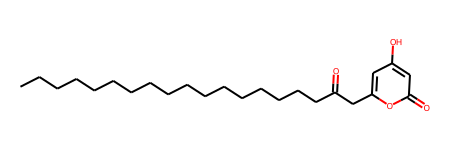

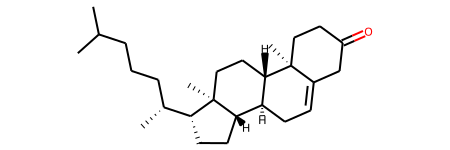

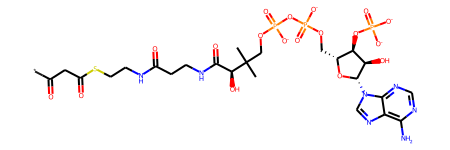

In [108]:
mols_smiles = list(set(df_UP_rhea_chebi_smiles.smiles.tolist()))
mols_rdkit = [Chem.MolFromSmiles(smi) for smi in mols_smiles]
rand_mols = sample(mols_rdkit, 3)
for mol in rand_mols:
    display(mol)


## Compute their Morgan fingerprints and cluster them: 

In [110]:
df_mols_uniq = df_UP_rhea_chebi_smiles[['ChEBI', 'smiles']].drop_duplicates()
df_mols_uniq.reset_index(inplace=True, drop=True)
mols_smiles = df_mols_uniq.smiles.tolist()

Xfp = []
for smi in mols_smiles:
    mol = Chem.MolFromSmiles(smi)
    Xfp.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius=3)))
Xfp = np.stack(Xfp, 0)

RDKit WARNING: [16:03:43] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:03:43] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [16:03:43] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:03:43] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [16:03:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:03:45] WARNING: not removing hydrogen atom with dummy atom neighbors


In [111]:
print(df_mols_uniq.shape)
Xfp.shape

(1139, 2)


(1139, 2048)

#### UMAP projection of Morgan fingerprints: 

In [130]:
seed = 184
np.random.seed(seed)
u_fp = umap.UMAP(random_state = seed, metric='jaccard', min_dist = 0, n_components = 3).fit_transform(Xfp)

/home/ajinich/miniconda3/lib/python3.8/site-packages/umap/umap_.py:1760: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


#### Add UMAP coordinates to compound dataframe

In [131]:
df_mols_uniq['u1'], df_mols_uniq['u2'], df_mols_uniq['u3'] = u_fp[:,0], u_fp[:,1], u_fp[:,2]
df_mols_uniq.head(2)

,ChEBI,smiles,u1,u2,u3
0,CHEBI_57327,C[C@@H](C([O-])=O)C(=O)SCCNC(=O)CCNC(=O)[C@H](...,3.305826,15.943238,5.922484
1,CHEBI_57783,NC(=O)C1=CN(C=CC1)[C@@H]1O[C@H](COP([O-])(=O)O...,-2.908326,3.605886,-1.523988


In [16]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/ajinich/miniconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random', 'seed']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
plt.figure(figsize=(14,7))

plt.scatter(df_mols_uniq_noCF['u1'], df_mols_uniq_noCF['u2'], s = 100, color = cols[-1], edgecolors='k', linewidths = 2, alpha = 0.7)

plt.xlabel('UMAP-1', fontsize = 24 )
plt.ylabel('UMAP-2', fontsize = 24 )
xt = plt.xticks(fontsize = 16)
yt = plt.yticks(fontsize = 16)

plt.tight_layout()

## Clustering:

### Cluster the compounds according to UMAP coordinates 

#### (should capture molecular structure): 

In [133]:
data = df_mols_uniq[['u1', 'u2', 'u3']].values

In [134]:
%%time
wcss, sil = choose_k(data, max_clus = 100)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:21<00:00,  4.63it/s]

CPU times: user 2min 32s, sys: 1.54 s, total: 2min 34s
Wall time: 21.2 s


In [135]:
wcss_plot = hv.Curve((wcss), label="Within cluster sum of squares").opts(
    xlabel="number of clusters",
    ylabel="WCSS",
    padding=0.1,
    tools=["hover"],
    color="orange",
)
silhouette_plot = hv.Curve((sil), label="silhouette score").opts(
    xlabel="number of clusters", ylabel="silhouette score", padding=0.1, tools=["hover"]
)

wcss_plot + silhouette_plot.opts(shared_axes = False)

:Layout
   .Curve.Within_cluster_sum_of_squares :Curve   [x]   (y)
   .Curve.Silhouette_score              :Curve   [x]   (y)

### Choose the optimal number of clusters and visualize:

In [138]:
df_mols_uniq

,ChEBI,smiles,u1,u2,u3,cluster_labels
0,CHEBI_57327,C[C@@H](C([O-])=O)C(=O)SCCNC(=O)CCNC(=O)[C@H](...,3.305826,15.943238,5.922484,10
1,CHEBI_57783,NC(=O)C1=CN(C=CC1)[C@@H]1O[C@H](COP([O-])(=O)O...,-2.908326,3.605886,-1.523988,23
2,CHEBI_64479,C(NC(CCNC(=O)[C@@H](C(COP(OC[C@@H](C(*)=O)N*)(...,12.578112,1.370632,-0.493632,3
3,CHEBI_83139,CC(C)(COP([O-])(=O)OP([O-])(=O)OC[C@H]1O[C@H](...,3.345856,16.015938,5.833848,10
4,CHEBI_16526,O=C=O,-0.668661,-0.549501,6.127844,0
...,...,...,...,...,...,...
1134,CHEBI_28689,[H][C@@]12CC=C3C[C@@H](O)CC[C@]3(C)[C@@]1([H])...,-0.318774,9.503427,3.201597,1
1135,CHEBI_83865,C[C@]12CC[C@H]3[C@@H](CC=C4CC(=O)CC[C@]34C)[C@...,-0.278128,9.507502,3.295506,1
1136,CHEBI_141140,O(P(OC[C@H]1O[C@@H](N2C=3N=CN=C(N)C3N=C2)[C@@H...,-2.676586,3.758908,-1.664882,23
1137,CHEBI_62225,[NH3+][C@@H](CSS([O-])(=O)=O)C([O-])=O,0.708042,-0.675666,4.119482,19


In [136]:
seed = 43
np.random.seed(seed)

num_clus = 27
clustering = KMeans(n_clusters = num_clus, random_state= seed).fit(data)
cluster_labels = clustering.labels_

df_mols_uniq['cluster_labels'] = cluster_labels

In [81]:
entry = 'P9WGB5'
df_UP_rhea_chebi_smiles[df_UP_rhea_chebi_smiles.Entry == entry ]

,Entry,RheaID,type,ChEBI,smiles
1903,P9WGB5,27826,LEFT,CHEBI_57661,[NH3+][C@@H](CCOC(=O)CCC([O-])=O)C([O-])=O
1904,P9WGB5,27826,LEFT,CHEBI_29919,[S-][H]
1905,P9WGB5,27826,RIGHT,CHEBI_30031,[O-]C(=O)CCC([O-])=O
1906,P9WGB5,27826,RIGHT,CHEBI_58199,[NH3+][C@@H](CCS)C([O-])=O


number of unique proteins: 1
['P9WPY3']


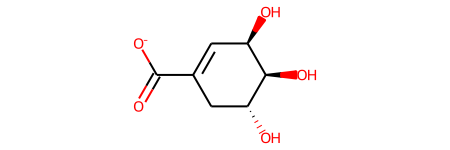

number of unique proteins: 1
['P9WND7']


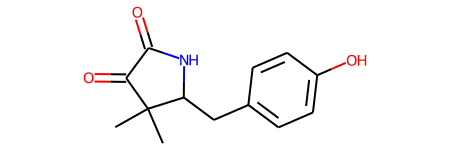

number of unique proteins: 1
['P9WJP3']


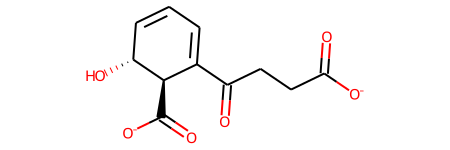

number of unique proteins: 2
['P9WFT1', 'P9WP77']


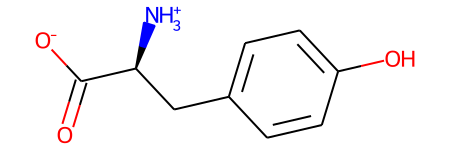

number of unique proteins: 1
['P9WNF9']


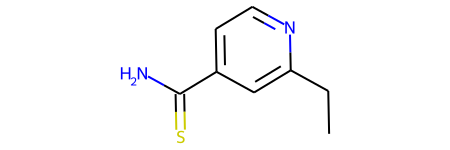

number of unique proteins: 2
['P9WQ39', 'P9WJP3']


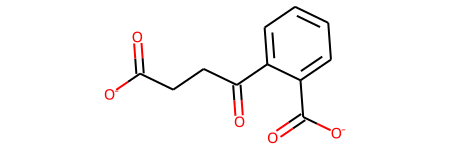

number of unique proteins: 3
['P9WK11', 'P9WFW9', 'P9WFX1']


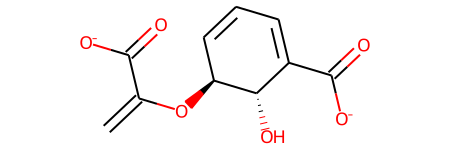

number of unique proteins: 4
['I6XD65', 'P9WP85', 'P9WJI7', 'P9WJI9']


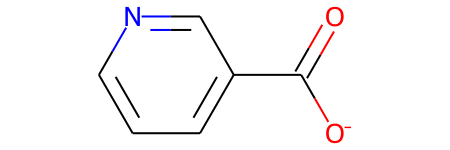

number of unique proteins: 2
['P9WHL1', 'P9WHK9']


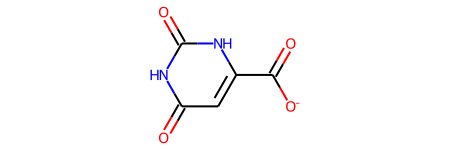

number of unique proteins: 1
['I6XD65']


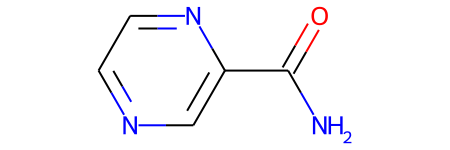

number of unique proteins: 1
['O50444']


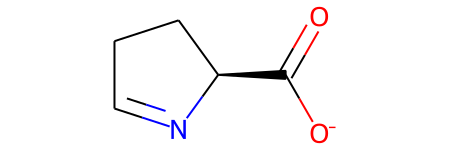

number of unique proteins: 2
['P9WND7', 'P9WP59']


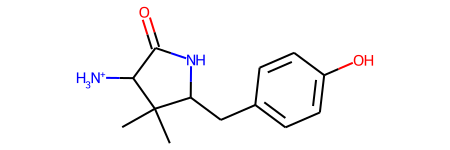

number of unique proteins: 5
['I6XD65', 'P9WLP9', 'O05442', 'P9WGG3', 'O53335']


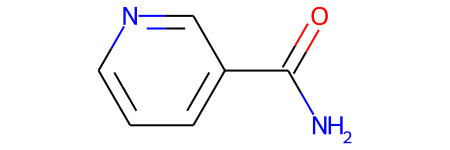

number of unique proteins: 1
['O69721']


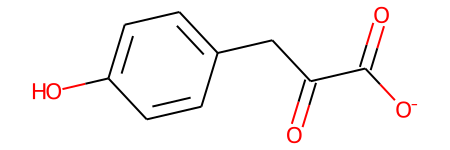

number of unique proteins: 8
['P9WFX3', 'P9WFX1', 'P9WIC5', 'P9WIC1', 'P9WN35', 'P9WIB9', 'P9WFW9', 'P9WPY1']


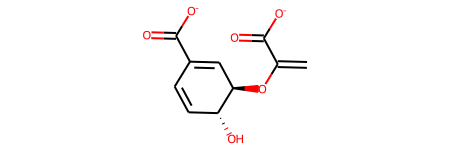

number of unique proteins: 2
['P9WPP7', 'P9WPF9']


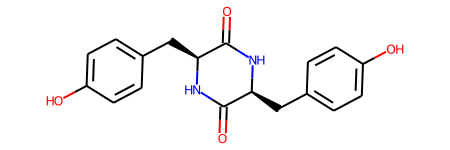

number of unique proteins: 2
['P9WJK1', 'P9WJJ7']


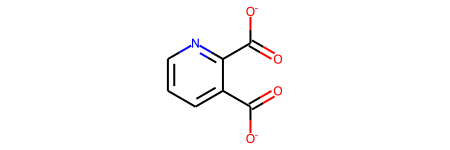

number of unique proteins: 1
['P9WPX7']


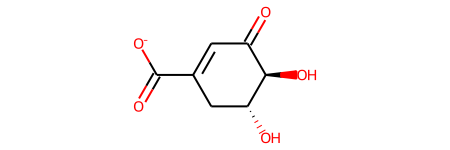

number of unique proteins: 1
['P95125']


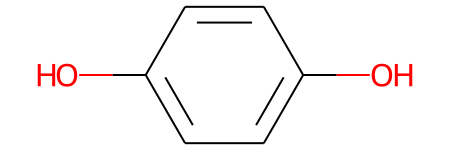

number of unique proteins: 1
['P9WND1']


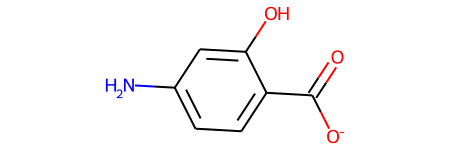

In [178]:
clus_num = 25
df_clus = df_mols_uniq[df_mols_uniq.cluster_labels.values == clus_num].copy()
# df_UP_rhea_chebi_smiles_clus = df_UP_rhea_chebi_smiles[df_UP_rhea_chebi_smiles.ChEBI.isin(df_clus.ChEBI)].copy()
df_sample = df_clus.sample(20)
smi_list = df_sample.smiles.tolist()
smi_list = list(set(smi_list))
for smi in smi_list:
    UP_ids = df_UP_rhea_chebi_smiles[df_UP_rhea_chebi_smiles.smiles==smi].Entry.tolist()
    UP_ids_unique = list(set(UP_ids))
    print('number of unique proteins:', len(UP_ids_unique))
    print(UP_ids_unique)
    display(Chem.MolFromSmiles(smi))

## Homework: make "y-vectors" for every cluster, and store them all in single dataframe

First, create a y-vector dataframe, for now just with the UP-ids:

In [159]:
file_in = '../data/annotations/uniprot-proteome_UP000001584.tab'
df = pd.read_csv(file_in, sep = '\t')
# Add RvIDs:
re_str = 'Rv\d\d\d\dc?'
list_rvids = [re.findall(re_str, str_temp)[0] for str_temp in df['Gene names']]
df['Rv_ID'] = list_rvids

# constrain to only proteins for which we have compound data: 
df_clus_y = df[df.Entry.isin(df_UP_rhea_chebi_smiles.Entry)].copy()
df_clus_y.shape

(860, 15)

In [ ]:
[col for col in df_clus_y.columns if "cluster" in col]

In [161]:
# clus_num = 1
for clus_num in df_mols_uniq.cluster_labels.unique():
    # get all compounds that fall in clus_num
    df_clus = df_mols_uniq[df_mols_uniq.cluster_labels.values == clus_num].copy()
    # get all unique up_ids that have those substrates: HINT: use the isin() function
    list_UP_unique = df_UP_rhea_chebi_smiles[df_UP_rhea_chebi_smiles.smiles.isin(df_clus.smiles)].Entry.unique().tolist()

    #### BASE OFF OF THIS SYNTAX
    col_name = 'cluster_'+str(clus_num)
    # enzymes that don't have substrates belonging to this cluster
    df_clus_y.loc[ ~df_clus_y.Entry.isin(list_UP_unique), col_name ] = 0
    # enzymes that *do* have substrates belonging to this cluster
    df_clus_y.loc[df_clus_y.Entry.isin(list_UP_unique), col_name ] = 1

In [163]:
fn = '../data/tests/df_clus_y.csv'
df_clus_y.to_csv(fn, index = False)

## For every cluster, count the number of unique Mtb proteins mapping to that cluster: 

In [33]:
list_clus = df_mols_uniq.cluster_labels.unique().tolist()
list_size_clus = []
list_str_UP_clus = []
for clus in list_clus:
    list_chebi_clus = df_mols_uniq[df_mols_uniq.cluster_labels==clus].ChEBI.tolist()
    df_UP_rhea_chebi_smiles_clus = df_UP_rhea_chebi_smiles[df_UP_rhea_chebi_smiles.ChEBI.isin(list_chebi_clus)].copy()
    list_UP_clus = df_UP_rhea_chebi_smiles_clus.Entry.unique().tolist()
    list_str_UP_clus.append(' '.join(list_UP_clus))
    size_clus = len(list_UP_clus)
    list_size_clus.append(size_clus)
df_clus_UP_size = pd.DataFrame()
df_clus_UP_size['cluster_labels'] = list_clus
df_clus_UP_size['size_clus'] = list_size_clus
df_clus_UP_size['list_UP_clus'] = list_str_UP_clus

In [34]:
df_clus_UP_size.sort_values(by = 'size_clus', ascending=False).head()

,cluster_labels,size_clus,list_UP_clus
1,10,355,A0A089QRB9 I6X235 I6X5C9 I6XD69 I6XI14 I6XWA1 ...
5,12,301,I6WXK4 I6X235 I6X5C9 I6XI14 I6Y0R5 I6Y2J4 I6Y4...
3,4,277,A0A089QRB9 I6WZK7 I6XD69 I6XU97 I6XWA1 I6Y2J4 ...
12,25,151,I6X9S5 I6XU97 I6Y2J4 I6Y9Q3 I6YEU0 I6YF08 I6YG...
13,15,137,I6X9S5 I6XI14 I6Y0R5 I6Y4C7 I6Y8S6 I6YG46 O332...


In [35]:
clus = 10
list_up_clus = df_clus_UP_size[df_clus_UP_size.cluster_labels==clus].list_UP_clus.values[0].split()
list_up_clus[:10]

['A0A089QRB9',
 'I6X235',
 'I6X5C9',
 'I6XD69',
 'I6XI14',
 'I6XWA1',
 'I6Y0R5',
 'I6Y4C7',
 'I6Y4V6',
 'I6Y778']

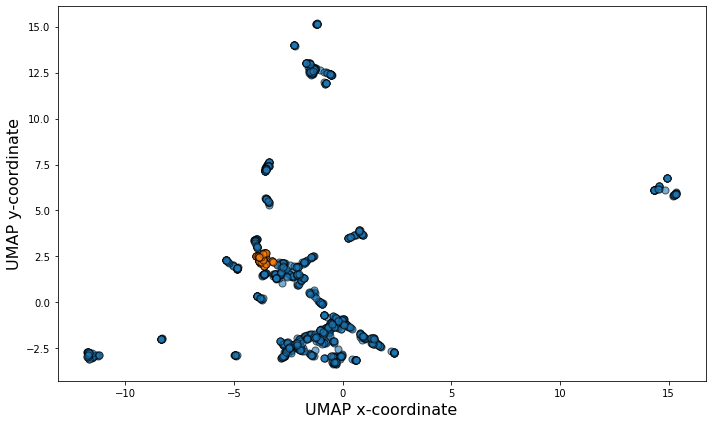

In [36]:
plt.figure(figsize=(10,6))
xdata = df_mols_uniq.u1
ydata = df_mols_uniq.u2
plt.scatter(xdata, ydata, s=50, edgecolors='k', alpha=0.6)

df_clus = df_mols_uniq[df_mols_uniq.cluster_labels==clus]
xdata = df_clus.u1
ydata = df_clus.u2
plt.scatter(xdata, ydata, s=50, edgecolors='k', alpha=0.6)
plt.xlabel('UMAP x-coordinate', fontsize = 16)
yl = plt.ylabel('UMAP y-coordinate', fontsize = 16)
plt.tight_layout()
# path_out = '../../figs/mohammed/mol_images/clustering.png'
# plt.savefig(path_out, dpi=300)

In [117]:
plt.figure(figsize=(6,6))
for clus in df_mols_uniq.cluster_labels.unique():
    df_clus = df_mols_uniq[df_mols_uniq.cluster_labels==clus]
    xdata = df_clus.u1
    ydata = df_clus.u2
    plt.scatter(xdata, ydata, s=200, edgecolors='k', alpha=0.6)
plt.xlabel('UMAP x-coordinate', fontsize = 16)
yl = plt.ylabel('UMAP y-coordinate', fontsize = 16)
plt.tight_layout()
# path_out = '../../figs/mohammed/mol_images/clustering.png'
# plt.savefig(path_out, dpi=300)

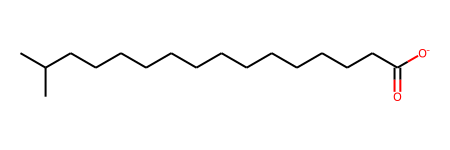

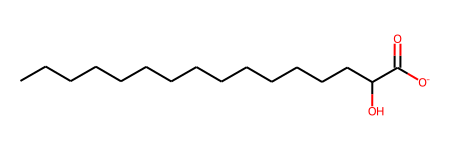

In [58]:

rand_mols = [Chem.MolFromSmiles(smi) for smi in smi_list]

# Draw.MolsToGridImage(mols_rdkit, subImgSize=(1000,1000), molsPerRow=3)
for mol in rand_mols:
    display(mol)

## Find metabolite-protein hubs: 

In [37]:
list_smi_unique = df_UP_rhea_chebi_smiles.smiles.unique()
# smi =list_smi_unique[0]

list_num_UP = []
list_str_chebi = []
list_str_UP = []
for smi in list_smi_unique:
    df_smi = df_UP_rhea_chebi_smiles[df_UP_rhea_chebi_smiles.smiles == smi]
    
    list_chebi = df_smi.ChEBI.unique().tolist()
    str_chebi = ' '.join(list_chebi)
    list_str_chebi.append(str_chebi)
    
    list_UP = df_smi.Entry.unique().tolist()
    str_UP = ' '.join(list_UP)
    list_str_UP.append(str_UP)
    
    num_UP = len(list_UP)
    list_num_UP.append(num_UP)
    
df_comp_count = pd.DataFrame()
df_comp_count['ChEBI'] = list_str_chebi
df_comp_count['num_UP'] = list_num_UP
df_comp_count['smiles'] = list_smi_unique
df_comp_count['Entries'] = list_str_UP

In [38]:
df_comp_count = df_comp_count.sort_values(by = 'num_UP', ascending=False)

### Display the top 20 hub metabolites

In [40]:
thresh = 40
df_comp_count_top = df_comp_count[df_comp_count.num_UP>=thresh].copy()

CHEBI_30616
number of proteins: 179
I6X5C9 I6XI14 I6Y0R5 I6Y4C7 I6Y4V6 I6Y8S6 I6YEU0 I6YFP0 O05307 O05575 O06417 O07177 O53347 O53348 O53521 O53551 O53580 O53637 O53676 O53701 O53873 P71538 P71716 P71913 P95141 P96271 P96379 P96843 P96890 P9WFS9 P9WFT1 P9WFT3 P9WFT5 P9WFT7 P9WFT9 P9WFU1 P9WFU3 P9WFU5 P9WFU7 P9WFU9 P9WFV1 P9WFV3 P9WFV5 P9WFV7 P9WFV9 P9WFW1 P9WFW3 P9WFW5 P9WFW7 P9WG53 P9WG71 P9WG77 P9WGC5 P9WGC7 P9WGC9 P9WGV1 P9WGW1 P9WGW3 P9WH05 P9WHG9 P9WHK5 P9WHK7 P9WHL5 P9WHL7 P9WHL9 P9WHM9 P9WHN1 P9WHU9 P9WHV7 P9WHV9 P9WI63 P9WI65 P9WI67 P9WI69 P9WI71 P9WI73 P9WI75 P9WI77 P9WI79 P9WI81 P9WI83 P9WID1 P9WID3 P9WID5 P9WID7 P9WIK1 P9WIL5 P9WIN1 P9WJH7 P9WJI7 P9WJI9 P9WJJ3 P9WJJ5 P9WJL1 P9WJL3 P9WJL5 P9WJL7 P9WJM9 P9WJS5 P9WKE1 P9WKE3 P9WKE5 P9WKE7 P9WKE9 P9WKF5 P9WKG7 P9WLZ7 P9WMK9 P9WMN1 P9WMP9 P9WMQ1 P9WMQ7 P9WMR3 P9WMR5 P9WMS7 P9WMU9 P9WN27 P9WN33 P9WN37 P9WN39 P9WN43 P9WN59 P9WN61 P9WN63 P9WNC7 P9WNM5 P9WNW5 P9WP29 P9WP31 P9WP97 P9WP99 P9WPA1 P9WPA3 P9WPA5 P9WPA7 P9WPA9 P9WPI9 P9WPK

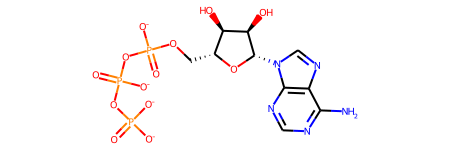

CHEBI_43474
number of proteins: 127
I6WXK4 I6X235 I6XI14 I6Y0R5 I6Y4C7 I6Y4V6 I6Y8S6 I6YEU0 O05575 O06401 O06563 O33194 O53289 O53335 O53347 O53348 O53361 O53512 O53873 O53907 P71538 P71615 P95189 P96271 P96374 P96890 P9WF11 P9WFF9 P9WFS1 P9WFZ5 P9WG59 P9WGC5 P9WGC7 P9WGJ3 P9WGV1 P9WGW1 P9WGW3 P9WGZ7 P9WH05 P9WHE9 P9WHK7 P9WHL5 P9WHL7 P9WHL9 P9WHM9 P9WHN1 P9WHN3 P9WHP1 P9WHV1 P9WHV5 P9WHW5 P9WI55 P9WI57 P9WIA1 P9WIC7 P9WII7 P9WII9 P9WIT7 P9WIT9 P9WIY3 P9WJI7 P9WJI9 P9WJK1 P9WJL1 P9WJL3 P9WJL5 P9WJL7 P9WJM1 P9WK97 P9WKD5 P9WKI9 P9WKJ1 P9WLH5 P9WLP9 P9WLZ7 P9WMK9 P9WMP9 P9WMQ1 P9WMQ7 P9WMR3 P9WMR5 P9WMV3 P9WMW1 P9WN21 P9WN27 P9WN37 P9WN39 P9WN59 P9WN61 P9WN83 P9WNX5 P9WP01 P9WP31 P9WP53 P9WP79 P9WP97 P9WPK3 P9WPK5 P9WPK7 P9WPK9 P9WPQ3 P9WPQ5 P9WPS3 P9WPS5 P9WPS7 P9WPS9 P9WPT1 P9WPT7 P9WPT9 P9WPU1 P9WPU3 P9WPU5 P9WPU7 P9WPX9 P9WPY1 P9WPY5 P9WPZ9 P9WQ17 P9WQA1 P9WQC9 P9WQK3 P9WQK9 P9WQL1 P9WQL3 P9WQM1 Q6MWZ7 Q79FV4


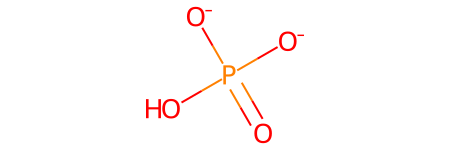

CHEBI_33019
number of proteins: 121
I6X5C9 I6YFP0 O05307 O05572 O05576 O06363 O06417 O06428 O50410 O53507 O53521 O53551 O53580 O53676 P71716 P95141 P96379 P96843 P9WFF3 P9WFF5 P9WFF7 P9WFR5 P9WFR7 P9WFS9 P9WFT1 P9WFT3 P9WFT5 P9WFT7 P9WFT9 P9WFU1 P9WFU3 P9WFU5 P9WFU7 P9WFU9 P9WFV1 P9WFV3 P9WFV5 P9WFV7 P9WFV9 P9WFW1 P9WFW3 P9WFW5 P9WFW7 P9WFX5 P9WG53 P9WG75 P9WGC9 P9WGV1 P9WGY5 P9WGY7 P9WGY9 P9WGZ1 P9WH13 P9WHF1 P9WHG9 P9WHK3 P9WHK9 P9WHQ7 P9WHQ9 P9WI55 P9WIK1 P9WIL5 P9WIP3 P9WIX9 P9WIY1 P9WJ61 P9WJI7 P9WJI9 P9WJJ3 P9WJJ5 P9WJJ7 P9WJM9 P9WJQ9 P9WJR5 P9WJR7 P9WJR9 P9WJS5 P9WJW1 P9WK27 P9WKG9 P9WKH1 P9WMM9 P9WMN1 P9WMN3 P9WMR7 P9WMS7 P9WMU9 P9WN27 P9WN29 P9WN33 P9WN43 P9WND1 P9WNM5 P9WNS5 P9WNT1 P9WNT3 P9WNT5 P9WNT7 P9WNT9 P9WNU5 P9WNW5 P9WNZ1 P9WP17 P9WP83 P9WPA5 P9WPF7 P9WPW7 P9WQ07 P9WQ35 P9WQ37 P9WQ39 P9WQ41 P9WQ43 P9WQ47 P9WQ51 P9WQ55 P9WQ57 P9WQ59 P9WQ61 P9WQD1 Q50631


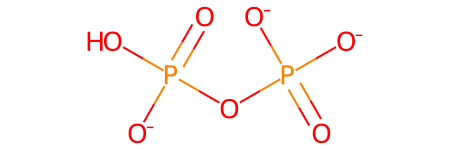

CHEBI_456216
number of proteins: 118
I6X5C9 I6XI14 I6Y0R5 I6Y4C7 I6Y4V6 I6Y8S6 I6YEU0 O05575 O07177 O53347 O53348 O53637 O53676 O53701 O53873 P71538 P71913 P96271 P96890 P9WF11 P9WG71 P9WG77 P9WGC5 P9WGC7 P9WGW1 P9WGW3 P9WH05 P9WHK5 P9WHK7 P9WHL5 P9WHL7 P9WHL9 P9WHM9 P9WHN1 P9WHU9 P9WHV7 P9WHV9 P9WI63 P9WI65 P9WI67 P9WI69 P9WI71 P9WI73 P9WI75 P9WI77 P9WI79 P9WI81 P9WI83 P9WID1 P9WID3 P9WID5 P9WID7 P9WIN1 P9WJH7 P9WJI7 P9WJI9 P9WJL1 P9WJL3 P9WJL5 P9WJL7 P9WKE1 P9WKE5 P9WKE7 P9WKE9 P9WKF5 P9WKG7 P9WLZ7 P9WMK9 P9WMP9 P9WMQ1 P9WMQ7 P9WMR3 P9WMR5 P9WMZ1 P9WN11 P9WN27 P9WN37 P9WN39 P9WN59 P9WN61 P9WN63 P9WNM5 P9WP29 P9WP31 P9WP97 P9WPA1 P9WPA3 P9WPA7 P9WPA9 P9WPI9 P9WPK1 P9WPK3 P9WPK5 P9WPK7 P9WPK9 P9WPQ3 P9WPQ5 P9WPS3 P9WPS5 P9WPS7 P9WPS9 P9WPT1 P9WPT7 P9WPT9 P9WPU1 P9WPU3 P9WPU5 P9WPU7 P9WPX3 P9WPY3 P9WQ01 P9WQA1 P9WQH1 P9WQK3 P9WQK9 P9WQL1 P9WQL3 P9WQM1


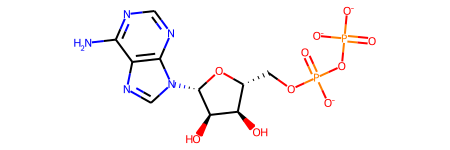

CHEBI_57287
number of proteins: 80
A0A089QRB9 I6XD69 I6XHI4 I6XHJ3 I6Y8R4 I6Y9Q3 I6YG32 O05307 O06159 O06417 O33289 O33336 O33364 O53181 O53182 O53521 O53551 O53581 P71725 P95231 P96202 P96843 P9WFK7 P9WG69 P9WGC5 P9WGC7 P9WHP1 P9WI61 P9WIK5 P9WIK7 P9WIN5 P9WIS5 P9WIS7 P9WJI5 P9WJM7 P9WJY9 P9WK17 P9WKA3 P9WKA5 P9WKA7 P9WKA9 P9WKB1 P9WKB3 P9WKB5 P9WKB7 P9WKB9 P9WKC1 P9WKC3 P9WKC5 P9WKC7 P9WKC9 P9WKY5 P9WM67 P9WMB5 P9WMN3 P9WNG3 P9WNG5 P9WP21 P9WPA3 P9WPD3 P9WPD5 P9WPF1 P9WPF3 P9WPZ3 P9WQ37 P9WQ39 P9WQ51 P9WQB3 P9WQD1 P9WQD3 P9WQD5 P9WQE1 P9WQE3 P9WQE5 P9WQE7 P9WQE9 P9WQH3 P9WQN9 P9WQP1 P9WQP3


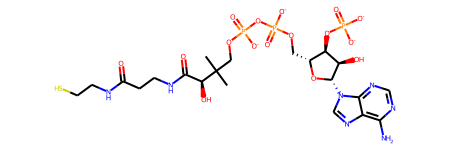

CHEBI_57540
number of proteins: 70
I6Y778 I6YCF0 L7N650 O05442 O07248 O07737 O50443 O53203 O53335 O53872 O69721 P71847 P71864 P71875 P95160 P95172 P95200 P96833 P96834 P9WGG3 P9WGR1 P9WGS9 P9WGT1 P9WHH3 P9WHH5 P9WHH7 P9WHH9 P9WHU7 P9WHV7 P9WIV5 P9WIV7 P9WIV9 P9WIW1 P9WIW5 P9WIW7 P9WIW9 P9WIX1 P9WIX3 P9WIX5 P9WJG9 P9WJH1 P9WJH3 P9WJH5 P9WJJ3 P9WK13 P9WK25 P9WKI7 P9WKK9 P9WLP9 P9WN75 P9WN77 P9WN83 P9WND9 P9WNP7 P9WNS7 P9WNW9 P9WNX3 P9WNY1 P9WNY5 P9WP23 P9WPX1 P9WQB1 P9WQB9 P9WQC1 P9WQC3 P9WQC7 P9WQH3 P9WQP7 Q10884 Q7ARS9


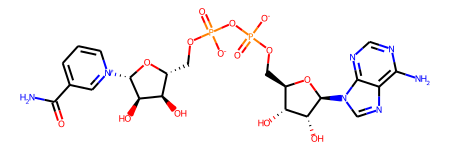

CHEBI_456215
number of proteins: 66
I6X235 I6XWA1 I6YFP0 O05307 O06417 O53521 O53551 O53580 P71615 P71716 P95141 P96379 P96843 P9WF11 P9WFS9 P9WFT1 P9WFT3 P9WFT5 P9WFT7 P9WFT9 P9WFU1 P9WFU3 P9WFU5 P9WFU7 P9WFU9 P9WFV1 P9WFV3 P9WFV5 P9WFV7 P9WFV9 P9WFW1 P9WFW3 P9WFW5 P9WFW7 P9WG53 P9WHG9 P9WHT7 P9WID5 P9WIK3 P9WIL5 P9WIX5 P9WJJ3 P9WJM9 P9WJQ5 P9WJQ7 P9WJS5 P9WKE3 P9WKF5 P9WKJ1 P9WMS7 P9WN33 P9WNC7 P9WP65 P9WPW7 P9WQ07 P9WQ37 P9WQ39 P9WQ41 P9WQ43 P9WQ47 P9WQ51 P9WQ55 P9WQ59 P9WQ61 P9WQD1 Q50631


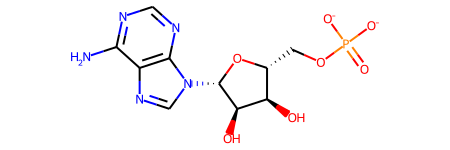

CHEBI_57945
number of proteins: 65
I6Y778 I6YCF0 L7N650 O07248 O07737 O50443 O53203 O53872 O69721 P71847 P71864 P71875 P95160 P95172 P95200 P96833 P96834 P9WF11 P9WGR1 P9WGS9 P9WGT1 P9WHH3 P9WHH5 P9WHH7 P9WHH9 P9WHU7 P9WIV5 P9WIV7 P9WIV9 P9WIW1 P9WIW5 P9WIW7 P9WIW9 P9WIX1 P9WIX3 P9WIX5 P9WJG9 P9WJH1 P9WJH3 P9WJH5 P9WK13 P9WK25 P9WKI7 P9WKK9 P9WN75 P9WN77 P9WN83 P9WND9 P9WNP7 P9WNS7 P9WNW9 P9WNX3 P9WNY1 P9WNY5 P9WP23 P9WPX1 P9WQB1 P9WQB9 P9WQC1 P9WQC3 P9WQC7 P9WQH3 P9WQP7 Q10884 Q7ARS9


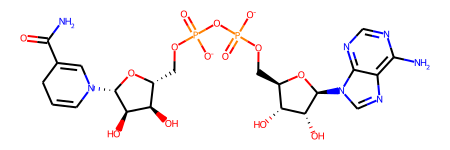

CHEBI_16526
number of proteins: 62
A0A089QRB9 I6XD69 I6YG46 O06334 O06335 O50408 O53181 O53182 O53554 O53611 O69721 P96202 P96878 P9WFE1 P9WFE7 P9WFE9 P9WFF1 P9WFX7 P9WG39 P9WG41 P9WG75 P9WGA9 P9WGY3 P9WHQ5 P9WIC3 P9WIH3 P9WIL3 P9WIP3 P9WIS1 P9WIS3 P9WIS5 P9WIS9 P9WIU3 P9WIU7 P9WJ79 P9WJJ7 P9WK11 P9WK25 P9WKJ3 P9WKK9 P9WKL1 P9WKZ1 P9WL45 P9WN53 P9WNG3 P9WNS3 P9WNZ1 P9WPF1 P9WPF3 P9WPJ7 P9WPJ9 P9WPQ5 P9WQ85 P9WQ87 P9WQD7 P9WQD9 P9WQE1 P9WQE3 P9WQE5 P9WQE7 P9WQE9 Q79FJ2


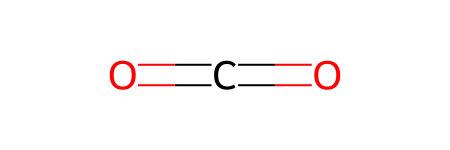

CHEBI_57783
number of proteins: 57
A0A089QRB9 I6XD69 O53611 P71791 P96202 P96218 P96833 P96834 P9WF11 P9WG57 P9WG81 P9WGT3 P9WH09 P9WHH1 P9WHH3 P9WHH5 P9WHH7 P9WHU7 P9WHV1 P9WIL1 P9WIQ3 P9WJI1 P9WJL9 P9WKF7 P9WKJ7 P9WKL1 P9WMP7 P9WN19 P9WN71 P9WN73 P9WN75 P9WN77 P9WNF9 P9WNP7 P9WNS1 P9WNS7 P9WNX1 P9WNX5 P9WNX7 P9WNX9 P9WNZ3 P9WP23 P9WP89 P9WPH1 P9WPL5 P9WPP3 P9WPX1 P9WPZ9 P9WQC5 P9WQE1 P9WQE3 P9WQE5 P9WQE7 P9WQE9 Q50631 Q79FJ2 Q7ARS9


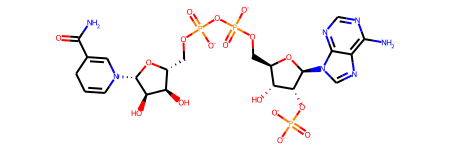

CHEBI_58349
number of proteins: 57
A0A089QRB9 I6XD69 O53611 P71791 P96202 P96218 P96833 P96834 P9WG57 P9WG81 P9WGT3 P9WH09 P9WHH1 P9WHH3 P9WHH5 P9WHH7 P9WHU7 P9WHV1 P9WHV7 P9WIL1 P9WIQ3 P9WJI1 P9WJL9 P9WKF7 P9WKJ7 P9WKL1 P9WMP7 P9WN19 P9WN71 P9WN73 P9WN75 P9WN77 P9WNF9 P9WNP7 P9WNS1 P9WNS7 P9WNX1 P9WNX5 P9WNX7 P9WNX9 P9WNZ3 P9WP23 P9WP89 P9WPH1 P9WPL5 P9WPP3 P9WPX1 P9WPZ9 P9WQC5 P9WQE1 P9WQE3 P9WQE5 P9WQE7 P9WQE9 Q50631 Q79FJ2 Q7ARS9


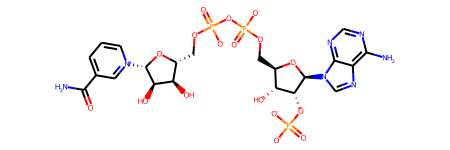

CHEBI_29985
number of proteins: 50
I6X9S5 I6XI14 I6Y0R5 I6Y4C7 I6Y8S6 I6YG46 O33289 O50443 O53203 O69670 O69689 P96218 P9WFV9 P9WFX3 P9WHK7 P9WHL5 P9WHL7 P9WHQ7 P9WHU9 P9WII7 P9WII9 P9WJJ3 P9WML7 P9WMM1 P9WMM3 P9WMS7 P9WN19 P9WN33 P9WN35 P9WN37 P9WN39 P9WN49 P9WN59 P9WN61 P9WP79 P9WP97 P9WPK3 P9WPK5 P9WPK7 P9WPK9 P9WPW9 P9WPZ3 P9WPZ5 P9WPZ7 P9WQ73 P9WQ75 P9WQ77 P9WQ79 P9WQ91 P9WQA1


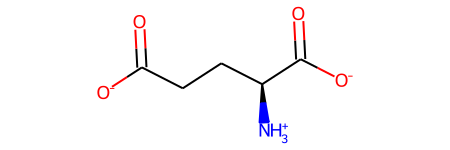

In [41]:
for index, row in df_comp_count_top.iterrows():
    print(row['ChEBI'])
    print('number of proteins:', row['num_UP'])
    print(row['Entries'])
    display(Chem.MolFromSmiles(row['smiles']))

### NEXT: Generate y-vector classification dataframe for all metabolite-protein hubs:

In [73]:
file_in = '../data/annotations/uniprot-proteome_UP000001584.tab'
df = pd.read_csv(file_in, sep = '\t')
# Add RvIDs:
re_str = 'Rv\d\d\d\dc?'
list_rvids = [re.findall(re_str, str_temp)[0] for str_temp in df['Gene names']]
df['Rv_ID'] = list_rvids

# constrain to only proteins for which we have compound data: 
df_train = df[df.Entry.isin(df_UP_rhea_chebi_smiles.Entry)].copy()
df_train.shape

(860, 15)

In [75]:
list_ChEBI = df_comp_count_top.ChEBI.tolist()
# chebi = list_ChEBI[0]
for chebi in list_ChEBI:
    list_entries = df_comp_count_top[df_comp_count_top.ChEBI==chebi].Entries.values[0].split()
    # df_train[df_train.Entry.isin(list_entries)]

    # enzymes that don't have substrates belonging to this cluster
    df_train..loc[~df_train.Entry.isin(list_entries), chebi] = 0
    # enzymes that *do* have substrates belonging to this cluster
    df_train.loc[df_train.Entry.isin(list_entries), chebi] = 1

hub metabolites to pool together: 

In [76]:
axp = ['CHEBI_30616', 'CHEBI_456216', 'CHEBI_456215'] #ATP, ADP, AMP
nads = ['CHEBI_57540', 'CHEBI_57945', 'CHEBI_57783', 'CHEBI_58349']
p_pp = ['CHEBI_43474', 'CHEBI_33019']# ortophosphate, diphosphate
list_ChEBI_pooled = [axp, nads, p_pp] 


In [77]:
for chebi_pooled in list_ChEBI_pooled:
    list_entries = df_UP_rhea_chebi_smiles[df_UP_rhea_chebi_smiles.ChEBI.isin(chebi_pooled)].Entry.unique().tolist()
    col_name = '-OR-'.join(chebi_pooled)
    # enzymes that don't have substrates belonging to this cluster
    df_train.loc[~df_train.Entry.isin(list_entries), col_name] = 0
    # enzymes that *do* have substrates belonging to this cluster
    df_train.loc[df_train.Entry.isin(list_entries), col_name] = 1

In [78]:
df_train.head(2)

,Entry,Entry name,Status,Protein names,Gene names,Organism,Length,Annotation,Rhea ID,EC number,...,CHEBI_57540,CHEBI_456215,CHEBI_57945,CHEBI_16526,CHEBI_57783,CHEBI_58349,CHEBI_29985,CHEBI_30616-OR-CHEBI_456216-OR-CHEBI_456215,CHEBI_57540-OR-CHEBI_57945-OR-CHEBI_57783-OR-CHEBI_58349,CHEBI_43474-OR-CHEBI_33019
1,P9WJM5,MSRA_MYCTU,reviewed,Peptide methionine sulfoxide reductase MsrA (P...,msrA Rv0137c MTCI5.11c,Mycobacterium tuberculosis (strain ATCC 25618 ...,182,4 out of 5,RHEA:14217; RHEA:19993,1.8.4.11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,P9WHM9,PUR2_MYCTU,reviewed,Phosphoribosylamine--glycine ligase (EC 6.3.4....,purD Rv0772 MTCY369.17,Mycobacterium tuberculosis (strain ATCC 25618 ...,422,3 out of 5,RHEA:17453,6.3.4.13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


Save to file: 

In [79]:
fn_out = '../data/tests/df_hub_metabolites.csv'
df_train.to_csv(fn_out, index=False)

________________________________
________________________________
________________________________
________________________________


_________________________________
_________________________________
_________________________________
_________________________________
_________________________________
_________________________________

# OTHER STUFF

In [65]:
df_45_l_rhea_chebi_smiles[df_45_l_rhea_chebi_smiles.ChEBI.isin(df_sample.ChEBI)].sample(5)

,Entry,RheaID,type,ChEBI,smiles
424,G3YG17,17025,RIGHT,CHEBI_17399,OC[C@H](O)[C@@H](O)C(=O)CO
2836,Q1MLL4,20685,LEFT,CHEBI_16813,OC[C@H](O)[C@@H](O)[C@@H](O)[C@H](O)CO
2650,P87219,14609,LEFT,CHEBI_17924,OC[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO
4005,Q8JIS3,18005,LEFT,CHEBI_48300,OC[C@@H](O)[C@H](O)CO
4003,Q8JIS3,17025,RIGHT,CHEBI_17399,OC[C@H](O)[C@@H](O)C(=O)CO


### Make a dataframe to train a classifier on: 

In [63]:
# Grab all compounds in the cluster(s) of interest:
list_clus = [3,9]
df_clus = df_mols_uniq_noCF[df_mols_uniq_noCF.cluster_labels.isin(list_clus)].copy()
print(df_clus.shape)

# Grab all proteins/entries that have substrates in those clusters: 
entries_clus = df_45_l_rhea_chebi_smiles_noCF[df_45_l_rhea_chebi_smiles_noCF.ChEBI.isin(df_clus.ChEBI)].Entry.unique().tolist()
print(len(entries_clus))

(62, 6)
53


In [64]:
df_cluster_classify = pd.DataFrame()
df_cluster_classify['Entry'] = df_45_l_rhea_chebi_smiles.Entry.unique()
# enzymes that don't have substrates belonging to this cluster
df_cluster_classify.loc[~df_cluster_classify.Entry.isin(entries_clus), 'compound_cluster'] = 0
# enzymes that *do* have substrates belonging to this cluster
df_cluster_classify.loc[df_cluster_classify.Entry.isin(entries_clus), 'compound_cluster'] = 1

In [67]:
file_out = '../../data/mohammed/beta_keto_AA_cluster_classify.csv'
df_cluster_classify.to_csv(file_out, index = False)

# Sankey diagram: 
## mapping protein embedding clusters to compound clusters: 

In [114]:
file_in = '../../data/mohammed/protein_clusters.csv'
df_prot = pd.read_csv(file_in)
df_prot.rename(columns={'cluster_labels':'protein_cluster'}, inplace=True)
print(df_prot.shape)
df_prot.head(2)

(4325, 2)


,Entry,protein_cluster
0,Q9NZC7,4
1,Q99714,7


In [48]:
df_mol = df_mols_uniq_noCF[['ChEBI', 'cluster_labels']].copy()
df_mol.rename(columns={'cluster_labels':'mol_cluster'}, inplace=True)
df_mol.head(2)

,ChEBI,mol_cluster
0,CHEBI_17336,7
1,CHEBI_17898,7


In [49]:
df_mapping = df_45_l_rhea_chebi_smiles_noCF[['Entry', 'ChEBI']].copy()

df_mapping_1 = df_mapping.merge(df_prot, how = 'left', on = 'Entry')
df_mapping_2 = df_mapping_1.merge(df_mol, how = 'left', on = 'ChEBI')
df_for_river = df_mapping_2[['protein_cluster', 'mol_cluster']].copy()

# save to file:
file_out = '../../data/mohammed/river_plot_v3.csv'
df_for_river.to_csv(file_out, index = False)

Start here: 

In [51]:
file_in = '../../data/mohammed/river_plot_v3.csv'
df_for_river = pd.read_csv(file_in)
df_for_river.sort_values(by = 'protein_cluster', inplace=True)

In [75]:
df_for_river_nonan = df_for_river[~np.isnan(df_for_river.protein_cluster.values)].copy()

In [76]:
df_for_river_nonan['protein_cluster'] = [str(int(v)) for v in df_for_river_nonan['protein_cluster'].values]
df_for_river_nonan['mol_cluster'] = [str(int(v)) for v in df_for_river_nonan['mol_cluster'].values]

In [54]:
sankey(
    df_for_river_nonan['protein_cluster'], df_for_river_nonan['mol_cluster'], aspect=20,
    fontsize=8, figureName="sankey_diagram_ChEBI"
)

In [88]:
for prot_clus in df_for_river_nonan.protein_cluster.unique():
    df_test = df_for_river_nonan[df_for_river_nonan.protein_cluster.values == prot_clus]
    print('protein cluster:', prot_clus, ' <----> number of mol. clusters:', len(df_test.mol_cluster.unique()))

protein cluster: 0  <----> number of mol. clusters: 11
protein cluster: 1  <----> number of mol. clusters: 18
protein cluster: 2  <----> number of mol. clusters: 19
protein cluster: 3  <----> number of mol. clusters: 15
protein cluster: 4  <----> number of mol. clusters: 19
protein cluster: 5  <----> number of mol. clusters: 13
protein cluster: 6  <----> number of mol. clusters: 15
protein cluster: 7  <----> number of mol. clusters: 17


In [92]:
df_prot[df_prot.protein_cluster.values == 5]

,Entry,protein_cluster
8,P16152,5
41,Q9C826,5
67,P35270,5
80,P39831,5
82,P07914,5
...,...,...
4256,A0A3B3UXD7,5
4257,H9H0U9,5
4268,A0A3Q2PC26,5
4269,A0A165K181,5


# Some more analyses: 

### How promiscuous are individual enzymes? 

In other words... is it that:
1. many single enzymes tend to (promiscuously) catalyze compounds that are structurally very different? OR...
2. enzymes tend to catalyze compounds in a single cluster, but enzymes in the same emb-1 cluster will catalyze compounds in different molecular clusters.  

In [99]:
df_45_l_rhea_chebi_noCF_clust = df_45_l_rhea_chebi_smiles_noCF[['Entry', 'RheaID', 'ChEBI']].merge(df_mols_uniq_noCF[['ChEBI', 'cluster_labels']], 
                                                                  on = 'ChEBI', how = 'inner')

In [105]:
list_up_uniq = df_45_l_rhea_chebi_noCF_clust.Entry.unique()

In [107]:
list_num_clus = []
for entry in list_up_uniq:
    num_clus = len(df_45_l_rhea_chebi_noCF_clust[df_45_l_rhea_chebi_noCF_clust.Entry.values == entry].cluster_labels.unique())
    list_num_clus.append(num_clus)

In [108]:
df_num_clus = pd.DataFrame()
df_num_clus['Entry'] = list_up_uniq
df_num_clus['num_clusters'] = list_num_clus 

In [111]:
df_num_clus['num_clusters'].value_counts()

1    220
2     94
3     19
4     17
5     11
Name: num_clusters, dtype: int64

In [152]:
df_num_clus[df_num_clus.num_clusters.values == 4].head(2)

,Entry,num_clusters
42,O14756,4
43,O54753,4


In [151]:
entry = 'O14756'
df_45_l_rhea_chebi_noCF_clust[df_45_l_rhea_chebi_noCF_clust.Entry.values == entry].head(2)

,Entry,RheaID,ChEBI,cluster_labels
42,O14756,21284,CHEBI_17336,7
43,O14756,48488,CHEBI_17336,7


In [176]:
clus_num = 2
df_45_l_rhea_chebi_noCF_clust[df_45_l_rhea_chebi_noCF_clust.cluster_labels.values == clus_num].sample(10)

,Entry,RheaID,ChEBI,cluster_labels
616,P28483,10740,CHEBI_17087,2
746,G5DGA8,45120,CHEBI_84966,2
1322,O14756,48488,CHEBI_83228,2
609,O75828,19257,CHEBI_17087,2
1831,P39831,43524,CHEBI_58320,2
467,A0A3Q8GLE8,61420,CHEBI_144481,2
1826,P39640,44628,CHEBI_84310,2
576,P26719,10736,CHEBI_17478,2
1738,P47727,63500,CHEBI_145547,2
1828,P39831,26438,CHEBI_33190,2


Sort the compounds in the given cluster by the number of "connections" to proteins: 

In [177]:
df_clus = df_45_l_rhea_chebi_noCF_clust[df_45_l_rhea_chebi_noCF_clust.cluster_labels.values == clus_num].copy()

In [203]:
chebi = 'CHEBI_13705'
df_clus[df_clus.ChEBI.values == chebi].head()

,Entry,RheaID,ChEBI,cluster_labels
706,D4A1J4,20521,CHEBI_13705,2
707,P29147,20521,CHEBI_13705,2
708,Q02337,20521,CHEBI_13705,2
709,Q02338,20521,CHEBI_13705,2
710,Q561X9,20521,CHEBI_13705,2


In [189]:
df_clus.ChEBI.value_counts()

CHEBI_17087     26
CHEBI_83228     20
CHEBI_17478     10
CHEBI_13705      8
CHEBI_10983      8
CHEBI_145547     7
CHEBI_145544     7
CHEBI_15687      3
CHEBI_142593     3
CHEBI_144481     2
CHEBI_58585      2
CHEBI_84966      2
CHEBI_84970      2
CHEBI_16583      2
CHEBI_58320      2
CHEBI_28868      2
CHEBI_57552      1
CHEBI_131847     1
CHEBI_16812      1
CHEBI_33384      1
CHEBI_33855      1
CHEBI_61904      1
CHEBI_58213      1
CHEBI_16510      1
CHEBI_84310      1
CHEBI_35235      1
CHEBI_16016      1
CHEBI_142621     1
CHEBI_58371      1
CHEBI_58246      1
CHEBI_58458      1
CHEBI_84358      1
CHEBI_33190      1
Name: ChEBI, dtype: int64

### A more detailed version of this question would be: 

For enzymes where the substrates all belong to a single structural cluster (num_clusters == 1):

+ how many individual substrates are there? (promiscuity within a structural cluster)

## For each compound cluster, how many unique proteins have substrates in that cluster? 

In [165]:
list_clust = df_45_l_rhea_chebi_noCF_clust.cluster_labels.unique().tolist()
list_num_prots = []
for clust in list_clust:
    num_prots = df_45_l_rhea_chebi_noCF_clust[df_45_l_rhea_chebi_noCF_clust.cluster_labels.values == clust].Entry.unique().shape[0]
    list_num_prots.append(num_prots)
    
df_clust_count = pd.DataFrame()
df_clust_count['cluster'] = list_clust
df_clust_count['num_prots'] = list_num_prots


In [169]:
df_mols_uniq_noCF.hvplot.scatter(x="u1", y="u2", padding=0.05, width = 1000, height = 500, size = 55, alpha = 0.7, 
                     hover_cols=['ChEBI'], line_color='k', c = 'cluster_labels', clabel = 'clusters', cmap = cc.glasbey[:20])


:Scatter   [u1]   (u2,cluster_labels,ChEBI)

## This below is your best study guide! 

In [173]:
df_clust_count.sort_values(by = 'num_prots', ascending=False)

,cluster,num_prots
0,7,80
4,2,65
7,19,65
6,5,57
12,16,57
2,3,53
3,1,31
11,6,25
14,8,25
8,11,17


# OTHER: 

## Alternative ways to cluster the substrates: 

BSL: puedes usar hbdscan para el clustering

In [144]:
clustering = DBSCAN(eps=3, min_samples=2).fit(Xfp)
df_mols_uniq_noCF['dbscan_labels'] = clustering.labels_

In [145]:
df_mols_uniq_noCF.hvplot.scatter(x="u1", y="u2", padding=0.05, width = 1000, height = 500, size = 55, alpha = 0.7, 
                     hover_cols=['ChEBI'], line_color='k', c = 'dbscan_labels', clabel = 'clusters', 
                                 cmap = cc.glasbey[:len(set(clustering.labels_))])


:Scatter   [u1]   (u2,dbscan_labels,ChEBI)

In [146]:
df_mols_uniq_noCF['dbscan_labels'].value_counts().head(4)

-1     263
 5      27
 35      6
 19      6
Name: dbscan_labels, dtype: int64